# SetUp

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import os
from scipy import stats
from collections import Counter,defaultdict
from datetime import datetime
from typing import Tuple, List
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random


# Practical 1:

## Download Dataset

In [2]:
# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Running in Colab - mount Drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd /content/gdrive/MyDrive/Colab Notebooks/Ml_scale/ml-32m
else:
    # Running locally
    %cd /Users/ethar/Desktop/Masters/MLscale/ml-32m

/Users/ethar/Desktop/Masters/MLscale/ml-32m


## Content Verfication

In [3]:
!md5sum links.csv movies.csv ratings.csv tags.csv

8f033867bcb4e6be8792b21468b4fa6e  links.csv
0df90835c19151f9d819d0822e190797  movies.csv
cf12b74f9ad4b94a011f079e26d4270a  ratings.csv
963bf4fa4de6b8901868fddd3eb54567  tags.csv


## Data Loading

In [4]:
print("Loading MovieLens 32M dataset...")

# Load ratings (chunk reading for memory efficiency)
ratings = pd.read_csv('ratings.csv',
                      dtype={'userId': 'int32', 'movieId': 'int32',
                             'rating': 'float32', 'timestamp': 'int64'})

# Load movies
movies = pd.read_csv('movies.csv')

print(f"Loaded {len(ratings):,} ratings")
print(f"Loaded {len(movies):,} movies")

Loading MovieLens 32M dataset...
Loaded 32,000,204 ratings
Loaded 87,585 movies


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


## Data Visualizaion (Plots)

In [6]:
# Create plots directory
os.makedirs('plots', exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [7]:
# Define color scheme
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'gradient_start': '#4A148C',
    'gradient_mid': '#00897B',
    'gradient_end': '#C6FF00'
}

# Create gradient colormap
from matplotlib.colors import LinearSegmentedColormap
colors_list = ['#4A148C', '#7B1FA2', '#00897B', '#26A69A', '#66BB6A', '#9CCC65', '#C6FF00']
n_bins = 100
cmap_custom = LinearSegmentedColormap.from_list('custom', colors_list, N=n_bins)


1. Creating Rating Distribution plot...


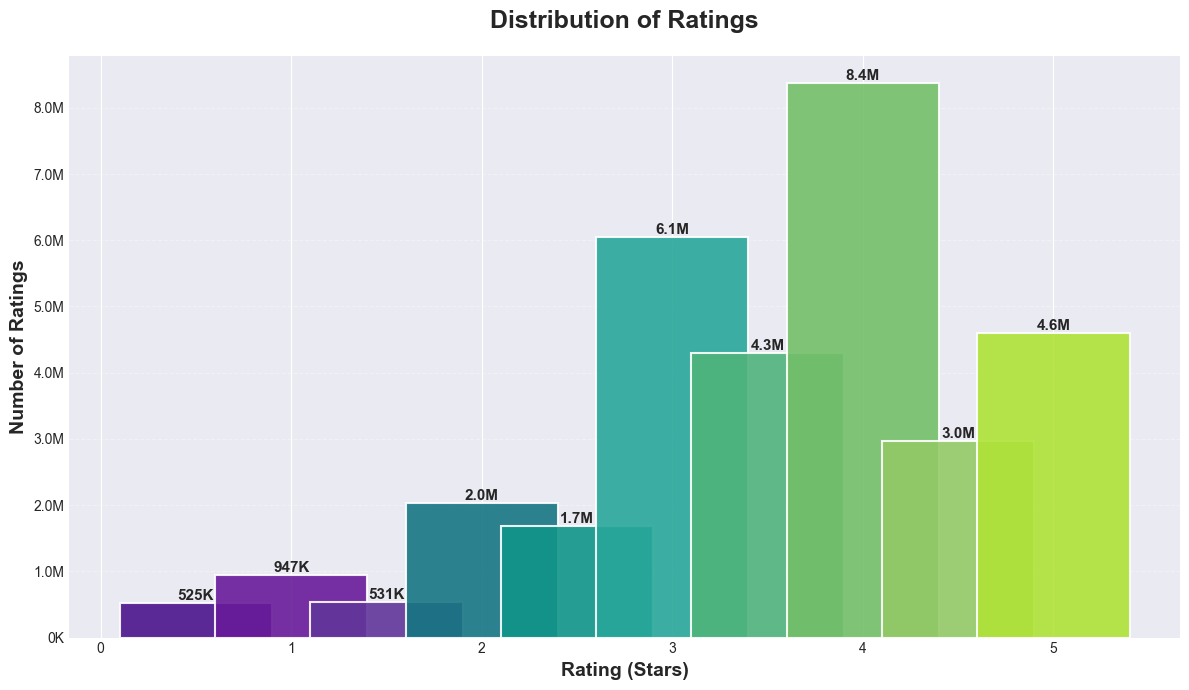

In [8]:
# ============================================================================
# 1. RATING DISTRIBUTION
# ============================================================================
print("\n1. Creating Rating Distribution plot...")

fig, ax = plt.subplots(figsize=(12, 7))

rating_counts = ratings['rating'].value_counts().sort_index()

# Create bars with gradient colors
bars = ax.bar(rating_counts.index, rating_counts.values,
              color=[cmap_custom(i/len(rating_counts)) for i in range(len(rating_counts))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e6:.1f}M' if height >= 1e6 else f'{height/1e3:.0f}K',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Rating (Stars)', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings', fontsize=18, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

plt.tight_layout()
plt.savefig('plots/01_rating_distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


2. Creating Combined Power Law plot...


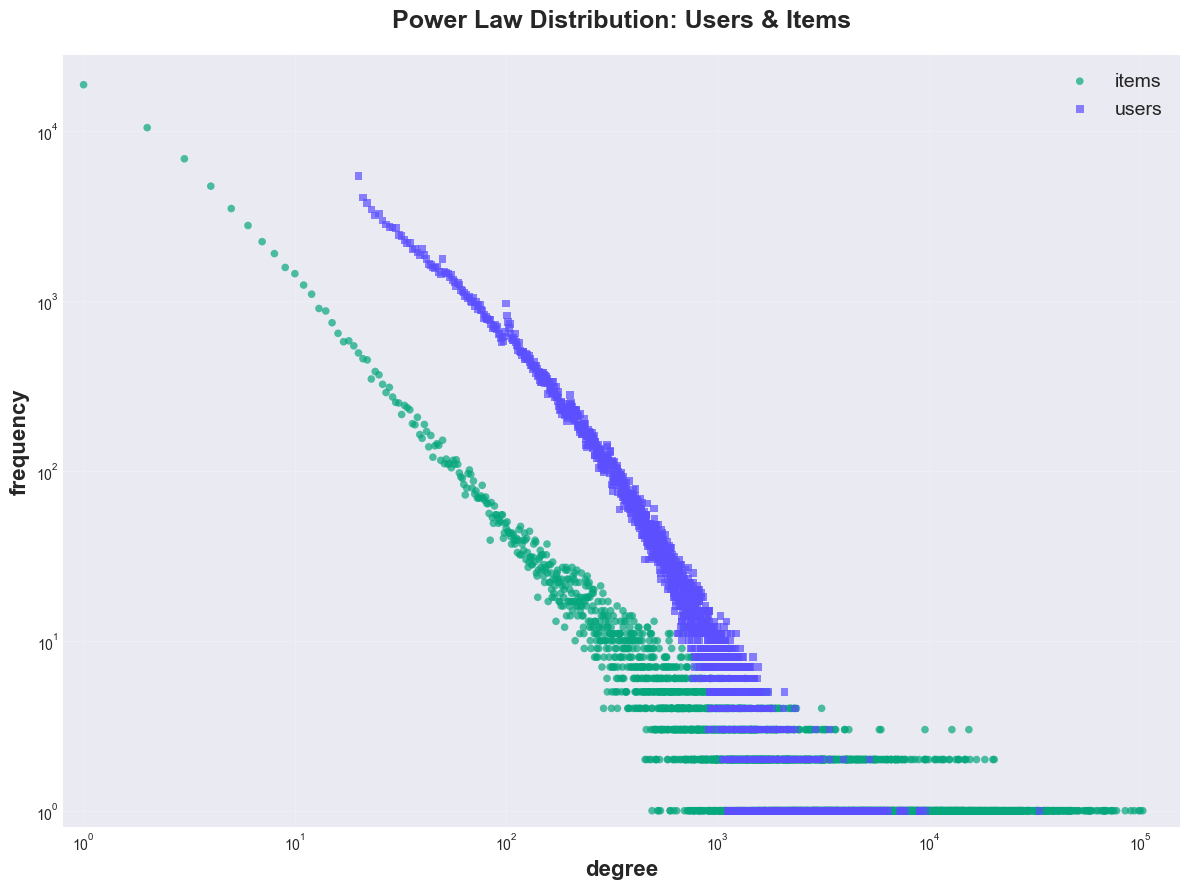

In [9]:
# ============================================================================
# 2. COMBINED POWER LAW (Users & Items)
# ============================================================================
print("\n2. Creating Combined Power Law plot...")

# Calculate ratings per user and movie
user_counts = ratings['userId'].value_counts().values
movie_counts = ratings['movieId'].value_counts().values

fig, ax = plt.subplots(figsize=(12, 9))

# Sort and create degree (number of ratings) vs frequency
# For users
user_degree_counts = Counter(user_counts)
user_degrees = np.array(sorted(user_degree_counts.keys()))
user_frequencies = np.array([user_degree_counts[d] for d in user_degrees])

# For movies (items)
movie_degree_counts = Counter(movie_counts)
movie_degrees = np.array(sorted(movie_degree_counts.keys()))
movie_frequencies = np.array([movie_degree_counts[d] for d in movie_degrees])

# Plot with scatter points
ax.scatter(movie_degrees, movie_frequencies,
           c='#06A77D', marker='o', s=30, alpha=0.7,
           label='items', edgecolors='none')
ax.scatter(user_degrees, user_frequencies,
           c='#5B4FFF', marker='s', s=30, alpha=0.7,
           label='users', edgecolors='none')

# Set log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('degree', fontsize=16, fontweight='bold')
ax.set_ylabel('frequency', fontsize=16, fontweight='bold')
ax.set_title('Power Law Distribution: Users & Items', fontsize=18, fontweight='bold', pad=20)

# Legend
ax.legend(fontsize=14, loc='upper right', framealpha=0.9)

# Grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Set axis limits for better visualization
ax.set_xlim(left=0.8, right=max(max(user_degrees), max(movie_degrees)) * 1.5)
ax.set_ylim(bottom=0.8, top=max(max(user_frequencies), max(movie_frequencies)) * 1.5)

plt.tight_layout()
plt.savefig('plots/02_combined_power_law.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


3. Creating Ratings per User Distribution...


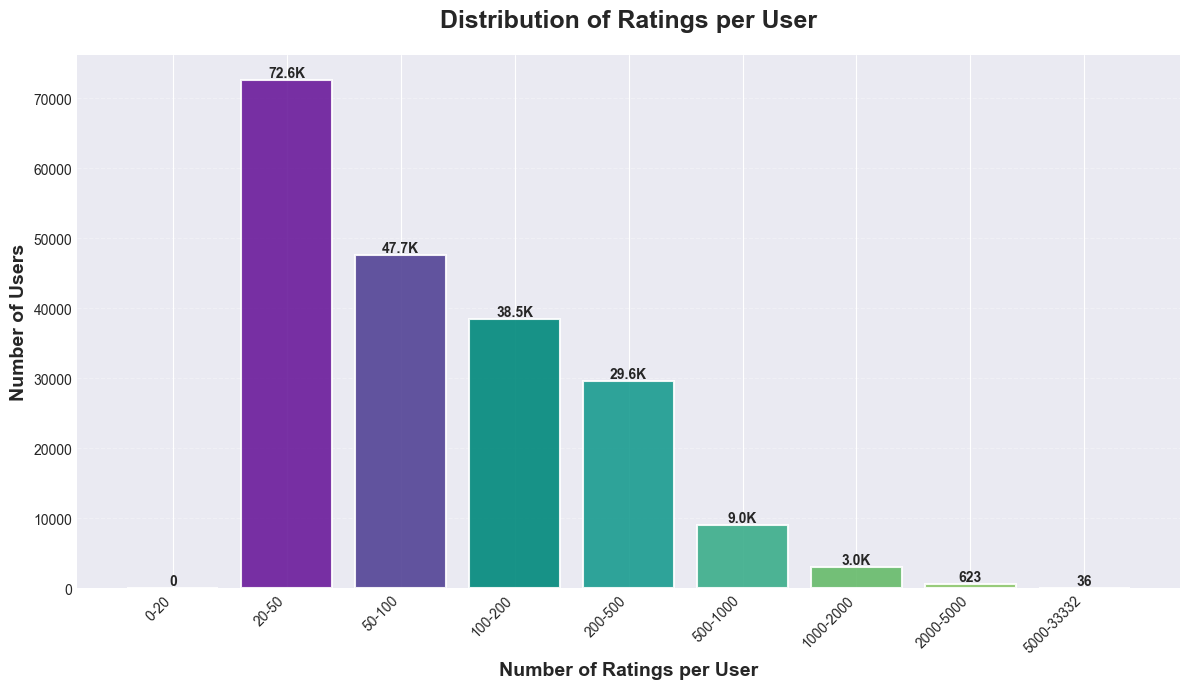

In [10]:
# ============================================================================
# 3. RATINGS PER USER DISTRIBUTION
# ============================================================================
print("\n3. Creating Ratings per User Distribution...")

fig, ax = plt.subplots(figsize=(12, 7))

# Use bins for efficiency
bins = [0, 20, 50, 100, 200, 500, 1000, 2000, 5000, max(user_counts)]
hist, edges = np.histogram(user_counts, bins=bins)

# Create bar positions
x_pos = range(len(hist))
labels = [f'{int(edges[i])}-{int(edges[i+1])}' for i in range(len(edges)-1)]

bars = ax.bar(x_pos, hist, color=[cmap_custom(i/len(hist)) for i in range(len(hist))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e3:.1f}K' if height >= 1e3 else f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Ratings per User', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Users', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings per User', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/03_ratings_per_user.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


4. Creating Ratings per Movie Distribution...


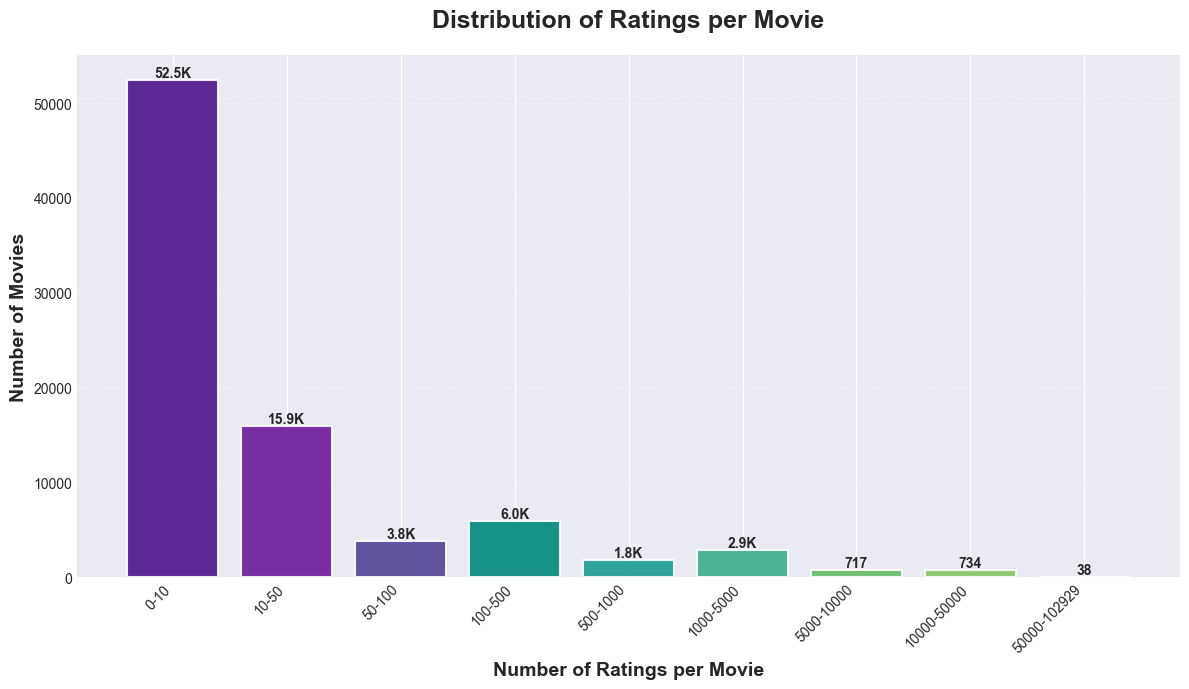

In [11]:
# ============================================================================
# 4. RATINGS PER MOVIE DISTRIBUTION
# ============================================================================
print("\n4. Creating Ratings per Movie Distribution...")

fig, ax = plt.subplots(figsize=(12, 7))

# Use bins for efficiency
bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, 50000, max(movie_counts)]
hist, edges = np.histogram(movie_counts, bins=bins)

x_pos = range(len(hist))
labels = [f'{int(edges[i])}-{int(edges[i+1])}' for i in range(len(edges)-1)]

bars = ax.bar(x_pos, hist, color=[cmap_custom(i/len(hist)) for i in range(len(hist))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e3:.1f}K' if height >= 1e3 else f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Ratings per Movie', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings per Movie', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/04_ratings_per_movie.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


5. Creating Top 20 Most Rated Movies...


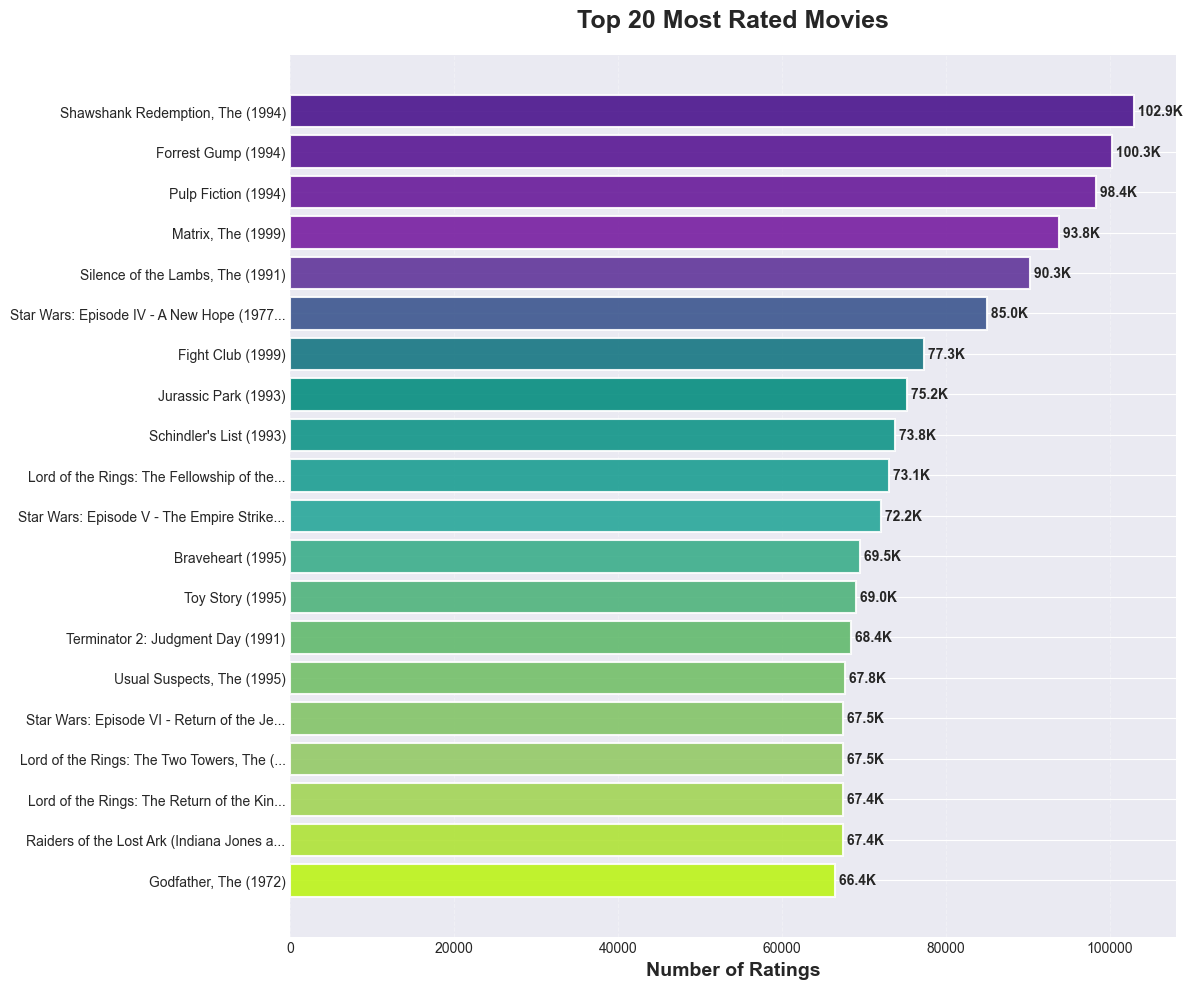

In [12]:
# ============================================================================
# 5. TOP 20 MOST RATED MOVIES
# ============================================================================
print("\n5. Creating Top 20 Most Rated Movies...")

top_movies = ratings['movieId'].value_counts().head(20)
top_movie_info = movies[movies['movieId'].isin(top_movies.index)].set_index('movieId')

fig, ax = plt.subplots(figsize=(12, 10))

# Create labels with movie titles
labels = [top_movie_info.loc[movie_id, 'title'][:40] + '...'
          if len(top_movie_info.loc[movie_id, 'title']) > 40
          else top_movie_info.loc[movie_id, 'title']
          for movie_id in top_movies.index]

y_pos = np.arange(len(labels))
colors = [cmap_custom(i/len(labels)) for i in range(len(labels))]

bars = ax.barh(y_pos, top_movies.values, color=colors,
               edgecolor='white', linewidth=1.5, alpha=0.9)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width/1e3:.1f}K',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Top 20 Most Rated Movies', fontsize=18, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/05_top_20_movies.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


6. Creating Rating Sparsity Matrix Visualization...


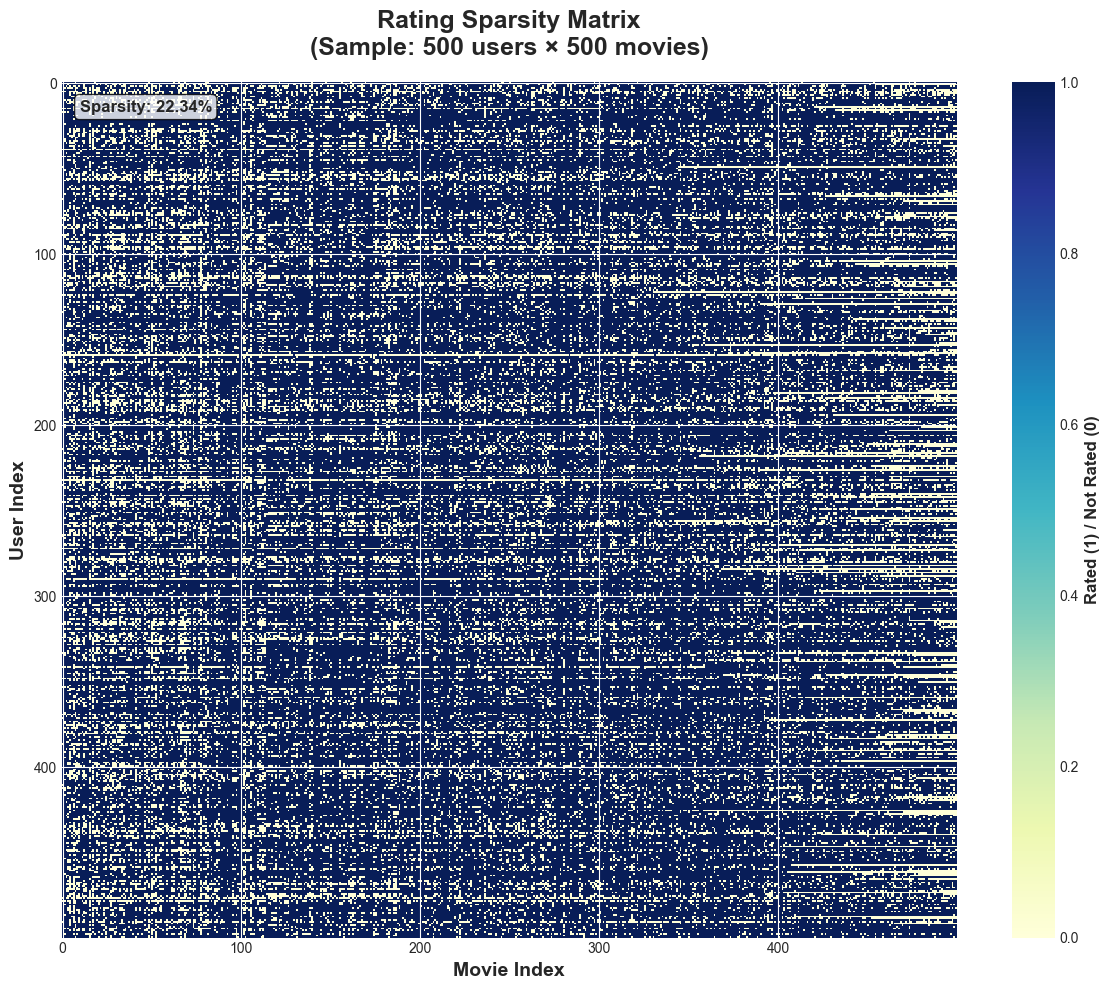

In [13]:
# ============================================================================
# 6. RATING SPARSITY MATRIX VISUALIZATION
# ============================================================================
print("\n6. Creating Rating Sparsity Matrix Visualization...")

# Sample for visualization (to avoid memory issues)
n_users_sample = 500
n_movies_sample = 500

# Get most active users and movies
top_users = ratings['userId'].value_counts().head(n_users_sample).index
top_movies_ids = ratings['movieId'].value_counts().head(n_movies_sample).index

# Create sparse matrix sample
sample_data = ratings[ratings['userId'].isin(top_users) &
                      ratings['movieId'].isin(top_movies_ids)]

# Create matrix
matrix = sample_data.pivot_table(index='userId', columns='movieId',
                                 values='rating', fill_value=0)

fig, ax = plt.subplots(figsize=(12, 10))

# Create sparsity visualization (binary: rated or not)
sparsity_matrix = (matrix > 0).astype(int)

im = ax.imshow(sparsity_matrix, cmap='YlGnBu', aspect='auto', interpolation='nearest')

ax.set_xlabel('Movie Index', fontsize=14, fontweight='bold')
ax.set_ylabel('User Index', fontsize=14, fontweight='bold')
ax.set_title(f'Rating Sparsity Matrix\n(Sample: {n_users_sample} users × {n_movies_sample} movies)',
             fontsize=18, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Rated (1) / Not Rated (0)', fontsize=12, fontweight='bold')

# Calculate and display sparsity
sparsity = 100 * (1 - np.sum(sparsity_matrix.values) / sparsity_matrix.size)
ax.text(0.02, 0.98, f'Sparsity: {sparsity:.2f}%',
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('plots/06_sparsity_matrix.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


7. Creating Rating Activity Over Time...


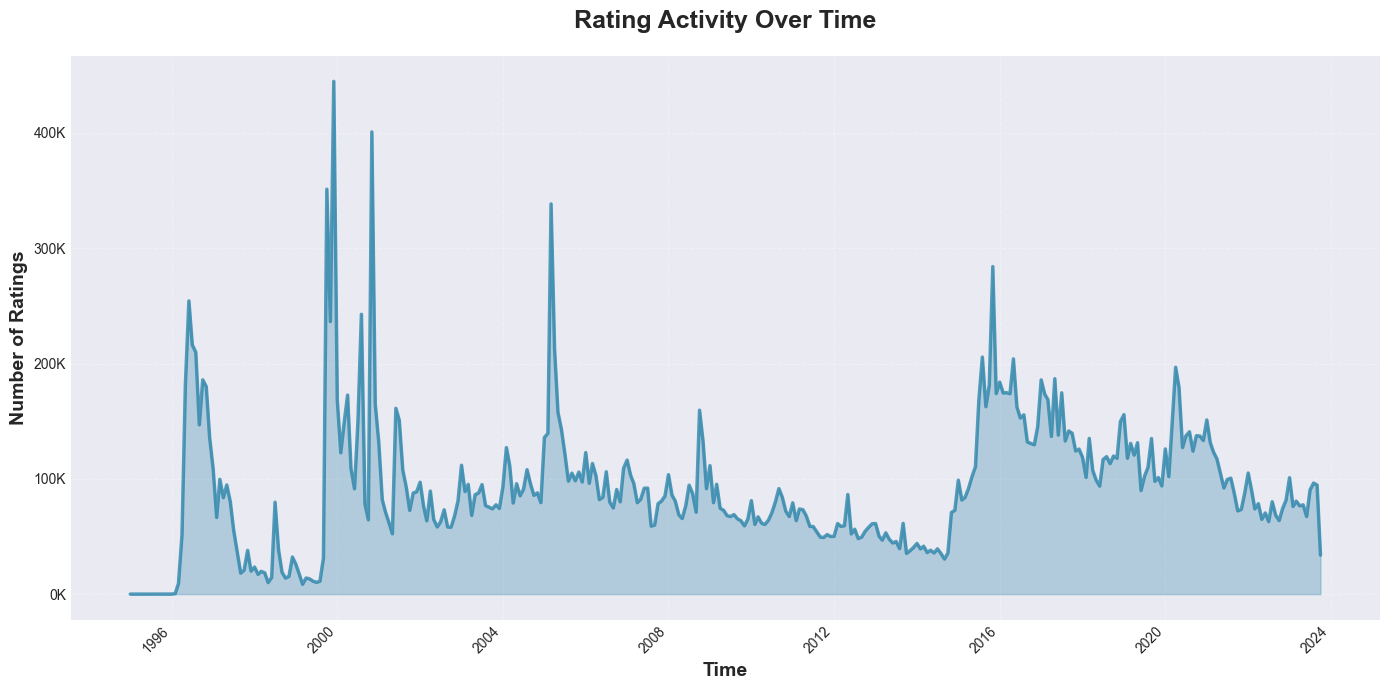

In [14]:
# ============================================================================
# 7. RATING ACTIVITY OVER TIME
# ============================================================================
print("\n7. Creating Rating Activity Over Time...")

# Convert timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year_month'] = ratings['datetime'].dt.to_period('M')

# Group by month
activity_over_time = ratings.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(14, 7))

# Convert period to timestamp for plotting
x_vals = activity_over_time.index.to_timestamp()
y_vals = activity_over_time.values

ax.plot(x_vals, y_vals, color=COLORS['primary'], linewidth=2.5, alpha=0.8)
ax.fill_between(x_vals, y_vals, alpha=0.3, color=COLORS['primary'])

ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Rating Activity Over Time', fontsize=18, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('plots/07_activity_over_time.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


8. Creating Genre Analysis...


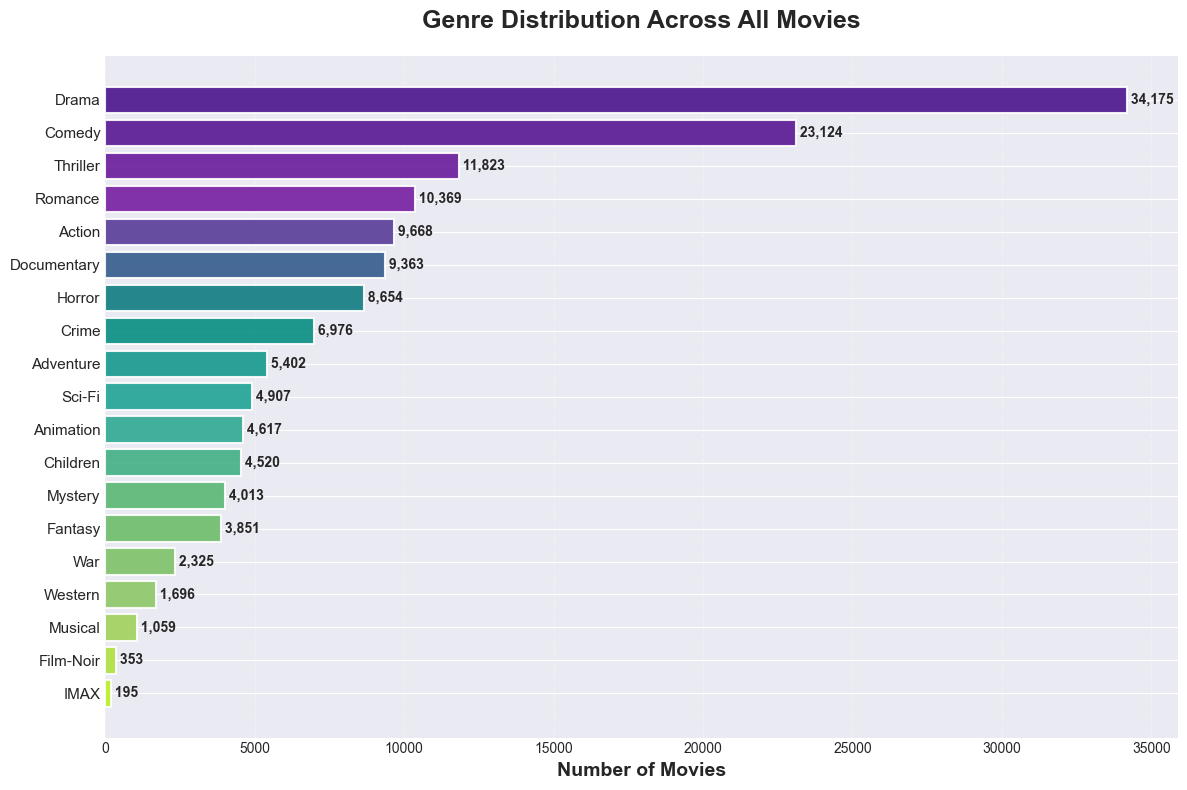

In [15]:
# ============================================================================
# 8. GENRE ANALYSIS
# ============================================================================
print("\n8. Creating Genre Analysis...")

# Extract genres
movies['genres_list'] = movies['genres'].str.split('|')
all_genres = []
for genres in movies['genres_list']:
    all_genres.extend(genres)

genre_counts = Counter(all_genres)
# Remove '(no genres listed)'
if '(no genres listed)' in genre_counts:
    del genre_counts['(no genres listed)']

genre_df = pd.DataFrame(genre_counts.most_common(), columns=['Genre', 'Count'])

fig, ax = plt.subplots(figsize=(12, 8))

colors = [cmap_custom(i/len(genre_df)) for i in range(len(genre_df))]
bars = ax.barh(range(len(genre_df)), genre_df['Count'], color=colors,
               edgecolor='white', linewidth=1.5, alpha=0.9)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width:,}',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(genre_df)))
ax.set_yticklabels(genre_df['Genre'], fontsize=11)
ax.set_xlabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_title('Genre Distribution Across All Movies', fontsize=18, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/08_genre_analysis.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Indexing Data_Structure

In [16]:
class SparseMatrix:
  def __init__(self, ratings):
    self.number_of_users = 0
    self.userid_to_idx  = {}
    self.idx_to_userid  = []
    self.data_by_user   = []

    self.number_of_movies = 0
    self.movieid_to_idx = {}
    self.idx_to_movieid = []
    self.data_by_movie  = []

    for rating in ratings:
      if not rating[0] in self.userid_to_idx:
        self.idx_to_userid.append(rating[0])
        self.userid_to_idx[rating[0]] = self.number_of_users
        self.number_of_users += 1
        self.data_by_user.append([])

      if not rating[1] in self.movieid_to_idx:
        self.idx_to_movieid.append(rating[1])
        self.movieid_to_idx[rating[1]] = self.number_of_movies
        self.number_of_movies += 1
        self.data_by_movie.append([])

      self.data_by_user[self.userid_to_idx[rating[0]]].append((self.movieid_to_idx[rating[1]],rating[2].item()))
      self.data_by_movie[self.movieid_to_idx[rating[1]]].append((self.userid_to_idx[rating[0]],rating[2].item()))


  def bin_search(self, array : list, value : int, key = lambda x:x):
    l = 0
    r = len(array)
    while r > l:
      m = (l+r)//2
      if value == key(array[m]):
        return m
      if value > key(array[m]):
        l = m+1
      else:
        r = m
    return -1

  def get_user_ratings(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings

  def get_ratings(self, userid, movieid):
    if not (userid in self.userid_to_idx and movieid in self.movieid_to_idx):
      return 0
    movie_ratings = self.get_user_ratings(userid)[1]
    idx = self.bin_search(movie_ratings, self.movieid_to_idx[movieid], key = lambda x:x[0])
    return movie_ratings[idx][1]


####################################################################################################


  def split(self, split_ratio):

    self.data_by_user_train  = []
    self.data_by_user_test   = []
    self.data_by_movie_train = []
    self.data_by_movie_test  = []

    for user_ratings in self.data_by_user:
      self.data_by_user_train.append([])
      self.data_by_user_test.append([])

      for rating in user_ratings:
        u = np.random.random()
        if u < split_ratio:
          self.data_by_user_train[-1].append(rating)
        else:
          self.data_by_user_test[-1].append(rating)

    for movie_ratings in self.data_by_movie:
      self.data_by_movie_train.append([])
      self.data_by_movie_test.append([])

    for user_idx, user_ratings in enumerate(self.data_by_user_train):
      for rating in user_ratings:
        self.data_by_movie_train[rating[0]].append((user_idx, rating[1]))


    for user_idx, user_ratings in enumerate(self.data_by_user_test):
      for rating in user_ratings:
        self.data_by_movie_test[rating[0]].append((user_idx, rating[1]))


    self.number_of_users_train = len(self.data_by_user_train)
    self.number_of_movies_train = len(self.data_by_movie_train)
    self.number_of_users_test = len(self.data_by_user_test)
    self.number_of_movies_test = len(self.data_by_movie_test)

    print(f"number of users in train dataset:  {self.number_of_users_train}")
    print(f"number of movies in train dataset: {self.number_of_movies_train}")
    print()
    print(f"number of users in test dataset:  {self.number_of_users_test}")
    print(f"number of movies in test dataset: {self.number_of_movies_test}")
    print(end = '\n')


    ratings_in_train = 0
    for user_ratings in self.data_by_user_train:
      for rating in user_ratings:
        ratings_in_train += 1

    ratings_in_test = 0
    for user_ratings in self.data_by_user_test:
      for rating in user_ratings:
        ratings_in_test += 1

    print(f"number of ratings in train dataset: {ratings_in_train}")
    print(f"number of ratings in test dataset: {ratings_in_test}")
    ratio = ratings_in_train/(ratings_in_train + ratings_in_test)
    print(f"split ratio: {ratio:0.2f}")






  # - - - - - - - - - data_train functions - - - - - - - - - #


  def get_user_ratings_train(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user_train[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings_train(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie_train[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings

  # - - - - - - - - - data_test functions - - - - - - - - - #


  def get_user_ratings_test(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user_test[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings_test(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie_test[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings


## Indexing Initialization

In [17]:
ratings = np.loadtxt(
    "ratings.csv",
    delimiter=",",
    skiprows=1,
    usecols=(0, 1, 2)
)

print(ratings.shape)

(32000204, 3)


In [18]:
ratings_matrix = SparseMatrix(ratings)

### Class Functions (Queries)

In [19]:
# Query user 1's ratings
n_ratings, user_ratings = ratings_matrix.get_user_ratings(1)
print(f"User 1 rated {n_ratings} movies")
print(user_ratings[:10])

# Query movie 1's ratings
n_ratings, movie_ratings = ratings_matrix.get_movie_ratings(1)
print(f"Movie 1 was rated by {n_ratings} users")
print(movie_ratings[:10])

# Get specific rating
rating = ratings_matrix.get_ratings(1, 17)
print(f"User 1's rating for movie 17: {rating}")

User 1 rated 141 movies
[(0, 4.0), (1, 1.0), (2, 2.0), (3, 5.0), (4, 5.0), (5, 2.0), (6, 1.0), (7, 5.0), (8, 3.0), (9, 5.0)]
Movie 1 was rated by 68997 users
[(9, 2.5), (10, 3.0), (16, 4.0), (18, 3.0), (19, 5.0), (22, 3.0), (23, 4.0), (27, 4.0), (32, 5.0), (33, 4.0)]
User 1's rating for movie 17: 4.0


# Practical 2:

## Train/ Test Split

In [20]:
ratings_matrix.split(0.9)

number of users in train dataset:  200948
number of movies in train dataset: 84432

number of users in test dataset:  200948
number of movies in test dataset: 84432

number of ratings in train dataset: 28800983
number of ratings in test dataset: 3199221
split ratio: 0.90


## Bias Only Optimization

In [21]:
user_biases = np.zeros(ratings_matrix.number_of_users)
movie_biases = np.zeros(ratings_matrix.number_of_movies)

lamda = 0.03
gamma = 0.01
iterations = 10

# For plotting
loss_history = []
rmse_history = []
rmse_test_history = []

for _ in range(iterations):
  for user_idx in range(ratings_matrix.number_of_users):
    bias = 0
    movie_counter = 0
    userid = ratings_matrix.idx_to_userid[user_idx]
    user_ratings = ratings_matrix.get_user_ratings_train(userid)[1]

    for movie_idx, rating in user_ratings:
      bias += lamda * (rating - movie_biases[movie_idx])
      movie_counter += 1
    if movie_counter > 0:
      bias = bias/(lamda * movie_counter + gamma)
      user_biases[user_idx] = bias


  for movie_idx in range(ratings_matrix.number_of_movies):
    bias = 0
    user_counter = 0
    movieid = ratings_matrix.idx_to_movieid[movie_idx]
    movie_ratings = ratings_matrix.get_movie_ratings_train(movieid)[1]

    for user_idx, rating in movie_ratings:
      bias += lamda * (rating - user_biases[user_idx])
      user_counter += 1
    if user_counter > 0:
      bias = bias/(lamda * user_counter + gamma)
      movie_biases[movie_idx] = bias

  loss_train = 0
  number_of_ratings_train = 0
  for user_idx, user_ratings in enumerate(ratings_matrix.data_by_user_train):
    for rating in user_ratings:
      pred = user_biases[user_idx] + movie_biases[rating[0]]
      r = rating[1]
      loss_train += (r - pred)**2
      number_of_ratings_train += 1
  rmse_train = np.sqrt(loss_train/number_of_ratings_train)

  loss_test = 0
  number_of_ratings_test = 0
  for user_idx, user_ratings in enumerate(ratings_matrix.data_by_user_test):
    for rating in user_ratings:
      pred = user_biases[user_idx] + movie_biases[rating[0]]
      r = rating[1]
      loss_test += (r - pred)**2
      number_of_ratings_test += 1
  rmse_test = np.sqrt(loss_test/number_of_ratings_test)

  print(f"Iteration {_+1}/{iterations}:\n "
      f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
      f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

  loss_history.append(loss_train)
  rmse_history.append(rmse_train)
  rmse_test_history.append(rmse_test)

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
print("="*60)


Iteration 1/10:
 Train RMSE = 0.8613, Train Loss = 21365458.8205 
 Test  RMSE = 0.8707, Test  Loss = 2425145.4669

Iteration 2/10:
 Train RMSE = 0.8470, Train Loss = 20660796.8565 
 Test  RMSE = 0.8564, Test  Loss = 2346393.2128

Iteration 3/10:
 Train RMSE = 0.8463, Train Loss = 20629073.8850 
 Test  RMSE = 0.8558, Test  Loss = 2342928.1990

Iteration 4/10:
 Train RMSE = 0.8463, Train Loss = 20627188.7277 
 Test  RMSE = 0.8557, Test  Loss = 2342717.0435

Iteration 5/10:
 Train RMSE = 0.8463, Train Loss = 20626897.8904 
 Test  RMSE = 0.8557, Test  Loss = 2342667.7390

Iteration 6/10:
 Train RMSE = 0.8463, Train Loss = 20626769.9271 
 Test  RMSE = 0.8557, Test  Loss = 2342636.2701

Iteration 7/10:
 Train RMSE = 0.8463, Train Loss = 20626693.4312 
 Test  RMSE = 0.8557, Test  Loss = 2342612.1871

Iteration 8/10:
 Train RMSE = 0.8463, Train Loss = 20626640.7850 
 Test  RMSE = 0.8557, Test  Loss = 2342592.0448

Iteration 9/10:
 Train RMSE = 0.8463, Train Loss = 20626599.6789 
 Test  RMSE = 

In [22]:
!pwd


/Users/ethar/Desktop/Masters/MLscale/ml-32m


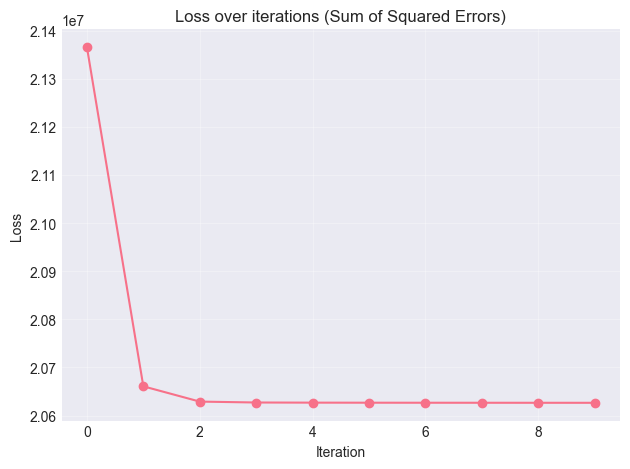

In [23]:
# --- Plot training loss ---


plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.grid(True, alpha= 0.3)
plt.savefig('plots_pdf/bias_only_loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


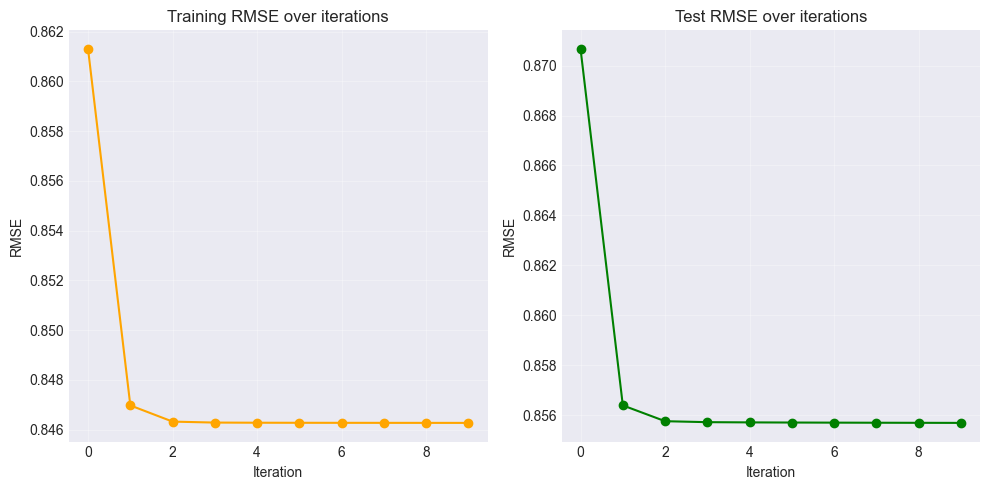

In [24]:
plt.figure(figsize=(10,5))
# --- Plot training RMSE ---
plt.subplot(1,2,1)
plt.plot(rmse_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.grid(True, alpha= 0.3)
# --- Plot test RMSE ---
plt.subplot(1,2,2)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.grid(True, alpha= 0.3)

plt.tight_layout()
plt.savefig('plots_pdf/bias_only_rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Practical 3:

In [25]:
def compute_loss(ratings_matrix, U, V, b_u, b_m, lamda, gamma_u, gamma_v, gamma_b, train=True):

    if train:
        data_by_user = ratings_matrix.data_by_user_train
    else:
        data_by_user = ratings_matrix.data_by_user_test

    # 1. Prediction error term
    squared_error = 0.0
    n_ratings = 0

    for user_idx, user_ratings in enumerate(data_by_user):
        for movie_idx, rating in user_ratings:
            # Prediction: u_u^T * v_m + b_u + b_m
            pred = np.dot(U[:,user_idx], V[:,movie_idx]) + b_u[user_idx] + b_m[movie_idx]

            # Squared error
            error = rating - pred
            squared_error += error ** 2
            n_ratings += 1


    # 2. Regularization terms
    # User embedding regularization: ||U||^2 = sum of all squared elements
    user_embedding_reg = np.sum(U ** 2)

    # Movie embedding regularization: ||V||^2
    movie_embedding_reg = np.sum(V ** 2)

    # Bias regularization
    user_bias_reg = np.sum(b_u ** 2)
    movie_bias_reg = np.sum(b_m ** 2)

    # 3. Full loss
    loss =(lamda / 2) * squared_error + \
          (gamma_u / 2) * user_embedding_reg + \
          (gamma_v / 2) * movie_embedding_reg + \
          (gamma_b / 2) * (user_bias_reg + movie_bias_reg)


    # 4. RMSE (for interpretability)
    rmse = np.sqrt(squared_error / n_ratings) if n_ratings > 0 else 0.0

    return loss, rmse


In [26]:
user_biases = np.zeros((ratings_matrix.number_of_users))
movie_biases = np.zeros((ratings_matrix.number_of_movies))
#############################
k = 20
user_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_users))
movie_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_movies))

lamda = 0.001
gamma_u = 0.01
gamma_v = 0.01
gamma_b = 0.1
iterations = 10

# For plotting
loss_history = []
rmse_history = []
rmse_test_history = []

for _ in range(iterations):
  for user_idx in range(ratings_matrix.number_of_users):
    bias = 0
    userid = ratings_matrix.idx_to_userid[user_idx]
    n_ratings, user_ratings = ratings_matrix.get_user_ratings_train(userid)
    if n_ratings == 0:
            continue
    # user bias update
    for movie_idx, rating in user_ratings:
      bias += lamda * (rating - movie_biases[movie_idx]- np.dot(user_embeddings[:,user_idx], movie_embeddings[:,movie_idx]))
    bias = bias/(lamda * n_ratings + gamma_b)
    user_biases[user_idx] = bias

    # user embedding update
    first_term = gamma_u * np.eye(movie_embeddings.shape[0])
    second_term = np.zeros(movie_embeddings.shape[0])
    for movie_idx, rating in user_ratings:
      v_n = movie_embeddings[:,movie_idx]
      first_term += lamda * np.outer(v_n, v_n)
      second_term += lamda * v_n * (rating - user_biases[user_idx] - movie_biases[movie_idx])
    # solving for u_m
    try:
      user_embeddings[:,user_idx] = np.linalg.solve(first_term, second_term)
    except np.linalg.LinAlgError:
      user_embeddings[:,user_idx] = np.linalg.lstsq(first_term, second_term, rcond=None)[0]

  for movie_idx in range(ratings_matrix.number_of_movies):
    bias = 0
    movieid = ratings_matrix.idx_to_movieid[movie_idx]
    m_ratings, movie_ratings = ratings_matrix.get_movie_ratings_train(movieid)
    if m_ratings == 0:
            continue

    for user_idx, rating in movie_ratings:
      bias += lamda * (rating - user_biases[user_idx]- np.dot(user_embeddings[:,user_idx], movie_embeddings[:,movie_idx]))
    bias = bias/(lamda * m_ratings + gamma_b)
    movie_biases[movie_idx] = bias

    first_term = gamma_v * np.eye(user_embeddings.shape[0])
    second_term = np.zeros(user_embeddings.shape[0])
    for user_idx, rating in movie_ratings:
      u_m = user_embeddings[:,user_idx]
      second_term += lamda * (u_m * (rating - user_biases[user_idx] - movie_biases[movie_idx]))
      first_term += lamda * np.outer(u_m, u_m)
    # solving for v_n
    try:
      movie_embeddings[:,movie_idx] = np.linalg.solve(first_term, second_term)
    except np.linalg.LinAlgError:
      movie_embeddings[:,movie_idx] = np.linalg.lstsq(first_term, second_term, rcond=None)[0]



  loss_train, rmse_train = compute_loss(ratings_matrix, user_embeddings, movie_embeddings, user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=True)
  loss_test, rmse_test = compute_loss(ratings_matrix, user_embeddings, movie_embeddings, user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=False)

  print(f"Iteration {_+1}/{iterations}:\n "
      f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
      f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

  loss_history.append(loss_train)
  rmse_history.append(rmse_train)
  rmse_test_history.append(rmse_test)

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
print("="*60)


Iteration 1/10:
 Train RMSE = 1.0307, Train Loss = 48154.0485 
 Test  RMSE = 1.1031, Test  Loss = 34803.3184

Iteration 2/10:
 Train RMSE = 0.7520, Train Loss = 24438.3149 
 Test  RMSE = 0.8334, Test  Loss = 17405.6385

Iteration 3/10:
 Train RMSE = 0.7132, Train Loss = 16387.7747 
 Test  RMSE = 0.8020, Test  Loss = 10092.2003

Iteration 4/10:
 Train RMSE = 0.7017, Train Loss = 13567.9889 
 Test  RMSE = 0.7943, Test  Loss = 7487.6014

Iteration 5/10:
 Train RMSE = 0.6962, Train Loss = 12194.8459 
 Test  RMSE = 0.7909, Test  Loss = 6215.9995

Iteration 6/10:
 Train RMSE = 0.6930, Train Loss = 11402.7424 
 Test  RMSE = 0.7889, Test  Loss = 5482.3157

Iteration 7/10:
 Train RMSE = 0.6910, Train Loss = 10897.4586 
 Test  RMSE = 0.7876, Test  Loss = 5014.2314

Iteration 8/10:
 Train RMSE = 0.6896, Train Loss = 10552.9272 
 Test  RMSE = 0.7868, Test  Loss = 4694.6022

Iteration 9/10:
 Train RMSE = 0.6887, Train Loss = 10306.5001 
 Test  RMSE = 0.7863, Test  Loss = 4465.2139

Iteration 10/10:

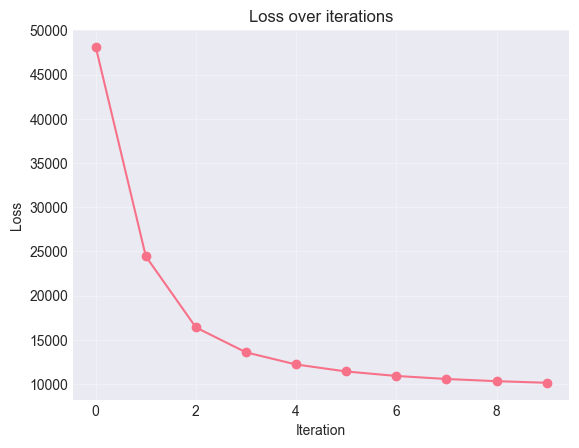

In [27]:
# --- Plot training loss ---
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.savefig('plots_pdf/embeddings_loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

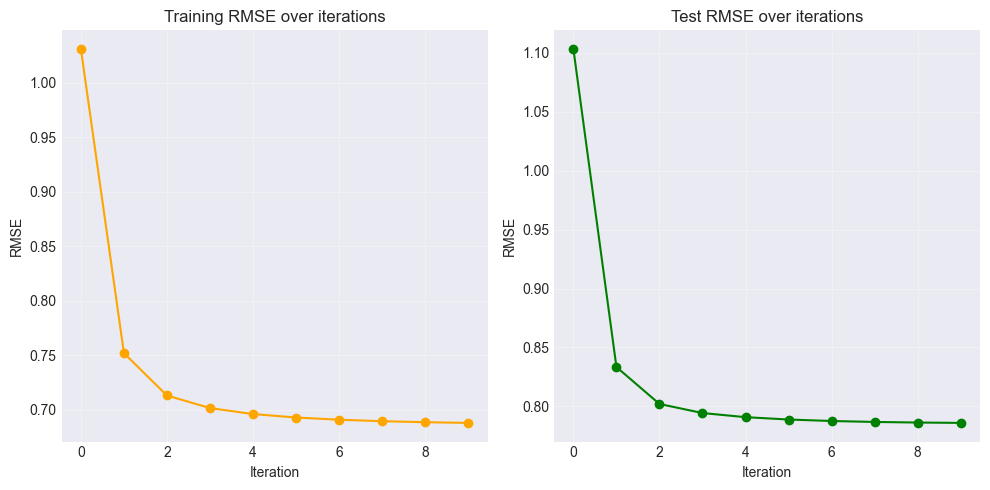

In [49]:
plt.figure(figsize=(10,5))
# --- Plot training RMSE ---
plt.subplot(1,2,1)
plt.plot(rmse_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)

# --- Plot test RMSE ---
plt.subplot(1,2,2)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots_pdf/embeddings_rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Practical 4:

In [29]:
df2 = pd.read_csv('movies.csv')
df2.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [36]:
def dummy_user_train(dummy_user_ratings, movie_embeddings, movie_biases, lamda, gamma_u, gamma_b, k = 10, iterations=10):
    dummy_user_embedding = np.random.normal(0, 0.1, size=(k,))
    dummy_bias = 0
    n_ratings = len(dummy_user_ratings)

    for _ in range(iterations):
        # Update bias in each iteration
        bias_sum = 0
        for movie_idx, rating in dummy_user_ratings:
            pred = movie_biases[movie_idx] + np.dot(dummy_user_embedding, movie_embeddings[:, movie_idx])
            bias_sum += lamda * (rating - pred)
        dummy_bias = bias_sum / (lamda * n_ratings + gamma_b)

        # Update embedding
        first_term = gamma_u * np.eye(k)
        second_term = np.zeros(k)

        for movie_idx, rating in dummy_user_ratings:
            v_n = movie_embeddings[:, movie_idx]
            first_term += lamda * np.outer(v_n, v_n)
            second_term += lamda * v_n * (rating - dummy_bias - movie_biases[movie_idx])

        try:
            dummy_user_embedding = np.linalg.solve(first_term, second_term)
        except np.linalg.LinAlgError:
            dummy_user_embedding = np.linalg.lstsq(first_term, second_term, rcond=None)[0]

    return dummy_user_embedding, dummy_bias

In [50]:
def dummy_user_recommendation(dummy_user_embedding, movie_embeddings,dummy_bias, movie_biases):
  score = np.zeros(movie_embeddings.shape[1])
  for movie_idx in range(movie_embeddings.shape[1]):
    n_ratings = ratings_matrix.get_movie_ratings(movie_idx)[0]
    # Calculate score
    if n_ratings < 100:
      score[movie_idx] = 0
    else:
      score[movie_idx] = (np.dot(dummy_user_embedding, movie_embeddings[:, movie_idx]) + movie_biases[movie_idx]* 0.05)

  ranked_items =  np.argsort(score)[::-1]

  return score, ranked_items

In [51]:
dummy_movie_ids = [122914]
dummy_ratings = [5.0]
dummy_movie_idx = []
dummy_user_ratings = []
n_rec = 20

for id, rating in zip(dummy_movie_ids, dummy_ratings):
    mov_idx = ratings_matrix.movieid_to_idx[id]
    dummy_movie_idx.append(mov_idx)
    dummy_user_ratings.append((mov_idx, rating))

dummy_user_embidding, dummy_bias = dummy_user_train(dummy_user_ratings,
                                        movie_embeddings,
                                        movie_biases,
                                        lamda = lamda,
                                        gamma_u = gamma_u,
                                        gamma_b = gamma_b,
                                        k = k,
                                        iterations = iterations
)
score, ranked_items = dummy_user_recommendation(dummy_user_embidding, movie_embeddings, dummy_bias, movie_biases)
# print(ranked_items[10:50], score[10:50], sep = '\n')


top_recommendations = []
# Filter out movies the user has already rated
for i in range(len(ranked_items)):
    if ranked_items[i] not in dummy_movie_idx:
        top_recommendations.append(ranked_items[i])
    if len(top_recommendations) >= n_rec:
        break


for i in range(len(top_recommendations)):
    recommendation_id = ratings_matrix.idx_to_movieid[top_recommendations[i]]
    row = df2[df2['movieId'] == recommendation_id][['title','genres']].values[0]
    print(*list(row))






Avengers: Infinity War - Part I (2018) Action|Adventure|Sci-Fi
Captain America: Civil War (2016) Action|Sci-Fi|Thriller
Avengers, The (2012) Action|Adventure|Sci-Fi|IMAX
Thor: Ragnarok (2017) Action|Adventure|Sci-Fi
Avengers: Age of Ultron (2015) Action|Adventure|Sci-Fi
Captain America: The Winter Soldier (2014) Action|Adventure|Sci-Fi|IMAX
Untitled Spider-Man Reboot (2017) Action|Adventure|Fantasy
Spider-Man: No Way Home (2021) Action|Adventure|Fantasy|Sci-Fi
Spider-Man: Far from Home (2019) Action|Adventure|Sci-Fi
Doctor Strange (2016) Action|Adventure|Sci-Fi
Black Panther (2017) Action|Adventure|Sci-Fi
Iron Man 3 (2013) Action|Sci-Fi|Thriller|IMAX
Deadpool (2016) Action|Adventure|Comedy|Sci-Fi
X-Men: Days of Future Past (2014) Action|Adventure|Sci-Fi
Guardians of the Galaxy (2014) Action|Adventure|Sci-Fi
Iron Man 2 (2010) Action|Adventure|Sci-Fi|Thriller|IMAX
Ant-Man and the Wasp (2018) Action|Adventure|Comedy|Fantasy|Sci-Fi
Thor (2011) Action|Adventure|Drama|Fantasy|IMAX
Thor: The 

In [52]:
# Add this after training the dummy user to see what's happening:
print("="*60)
print("DEBUGGING DUMMY USER")
print("="*60)

# Check the rated movies
print("\nRated Movies:")
for movie_id in dummy_movie_ids:
    row = df2[df2['movieId'] == movie_id][['title','genres']].values[0]
    print(f"  MovieID {movie_id}: {row[0]} ({row[1]})")

# Check embedding magnitude
print(f"\nDummy user embedding norm: {np.linalg.norm(dummy_user_embidding):.4f}")
print(f"Dummy user bias: {dummy_bias:.4f}")

# Check score distribution
print(f"\nScore statistics:")
print(f"  Min score: {score.min():.4f}")
print(f"  Max score: {score.max():.4f}")
print(f"  Mean score: {score.mean():.4f}")
print(f"  Std score: {score.std():.4f}")

# Check your rated movies' scores
print(f"\nScores for YOUR rated movies:")
for movie_idx in dummy_movie_idx:
    movie_id = ratings_matrix.idx_to_movieid[movie_idx]
    row = df2[df2['movieId'] == movie_id][['title']].values[0][0]
    print(f"  {row}: {score[movie_idx]:.4f}")

# Check top recommendations with scores
print(f"\nTop 10 Recommendations with scores:")
for i in range(n_rec):
    rec_idx = top_recommendations[i]
    rec_id = ratings_matrix.idx_to_movieid[rec_idx]
    row = df2[df2['movieId'] == rec_id][['title','genres']].values[0]
    print(f"  {i+1}. Score: {score[rec_idx]:.4f} - {row[0]} ({row[1]})")

DEBUGGING DUMMY USER

Rated Movies:
  MovieID 122914: Avengers: Infinity War - Part II (2019) (Action|Adventure|Sci-Fi)

Dummy user embedding norm: 0.4463
Dummy user bias: 0.0079

Score statistics:
  Min score: -1.0955
  Max score: 2.6011
  Mean score: 0.0098
  Std score: 0.0798

Scores for YOUR rated movies:
  Avengers: Infinity War - Part II (2019): 2.6011

Top 10 Recommendations with scores:
  1. Score: 2.5924 - Avengers: Infinity War - Part I (2018) (Action|Adventure|Sci-Fi)
  2. Score: 2.2309 - Captain America: Civil War (2016) (Action|Sci-Fi|Thriller)
  3. Score: 2.1566 - Avengers, The (2012) (Action|Adventure|Sci-Fi|IMAX)
  4. Score: 2.1046 - Thor: Ragnarok (2017) (Action|Adventure|Sci-Fi)
  5. Score: 2.0994 - Avengers: Age of Ultron (2015) (Action|Adventure|Sci-Fi)
  6. Score: 2.0811 - Captain America: The Winter Soldier (2014) (Action|Adventure|Sci-Fi|IMAX)
  7. Score: 1.8382 - Untitled Spider-Man Reboot (2017) (Action|Adventure|Fantasy)
  8. Score: 1.7692 - Spider-Man: No Way

# Polarizing Movies

In [53]:
n_polorizing_movies = 30
norms = []
for movie_idx in range(movie_embeddings.shape[1]):
  movie = np.linalg.norm(movie_embeddings[:,movie_idx])
  norms.append(movie)

movies_idx_sorted_by_norm = np.argsort(norms)[::-1]
polorizing_movies_id = [ratings_matrix.idx_to_movieid[idx] for idx in movies_idx_sorted_by_norm[:n_polorizing_movies]]

for movie_id in polorizing_movies_id:
  row = df2[df2['movieId'] == movie_id][['title','genres']].values[0]
  print(*list(row))

Natural Born Killers (1994) Action|Crime|Thriller
Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
Star Wars: Episode I - The Phantom Menace (1999) Action|Adventure|Sci-Fi
Dumb & Dumber (Dumb and Dumber) (1994) Adventure|Comedy
Ace Ventura: Pet Detective (1994) Comedy
Ace Ventura: When Nature Calls (1995) Comedy
Star Wars: Episode II - Attack of the Clones (2002) Action|Adventure|Sci-Fi|IMAX
Harry Potter and the Half-Blood Prince (2009) Adventure|Fantasy|Mystery|Romance|IMAX
Harry Potter and the Deathly Hallows: Part 1 (2010) Action|Adventure|Fantasy|IMAX
Star Wars: Episode III - Revenge of the Sith (2005) Action|Adventure|Sci-Fi
Rocky Horror Picture Show, The (1975) Comedy|Horror|Musical|Sci-Fi
Harry Potter and the Goblet of Fire (2005) Adventure|Fantasy|Thriller|IMAX
Harry Potter and the Order of the Phoenix (2

# Feature

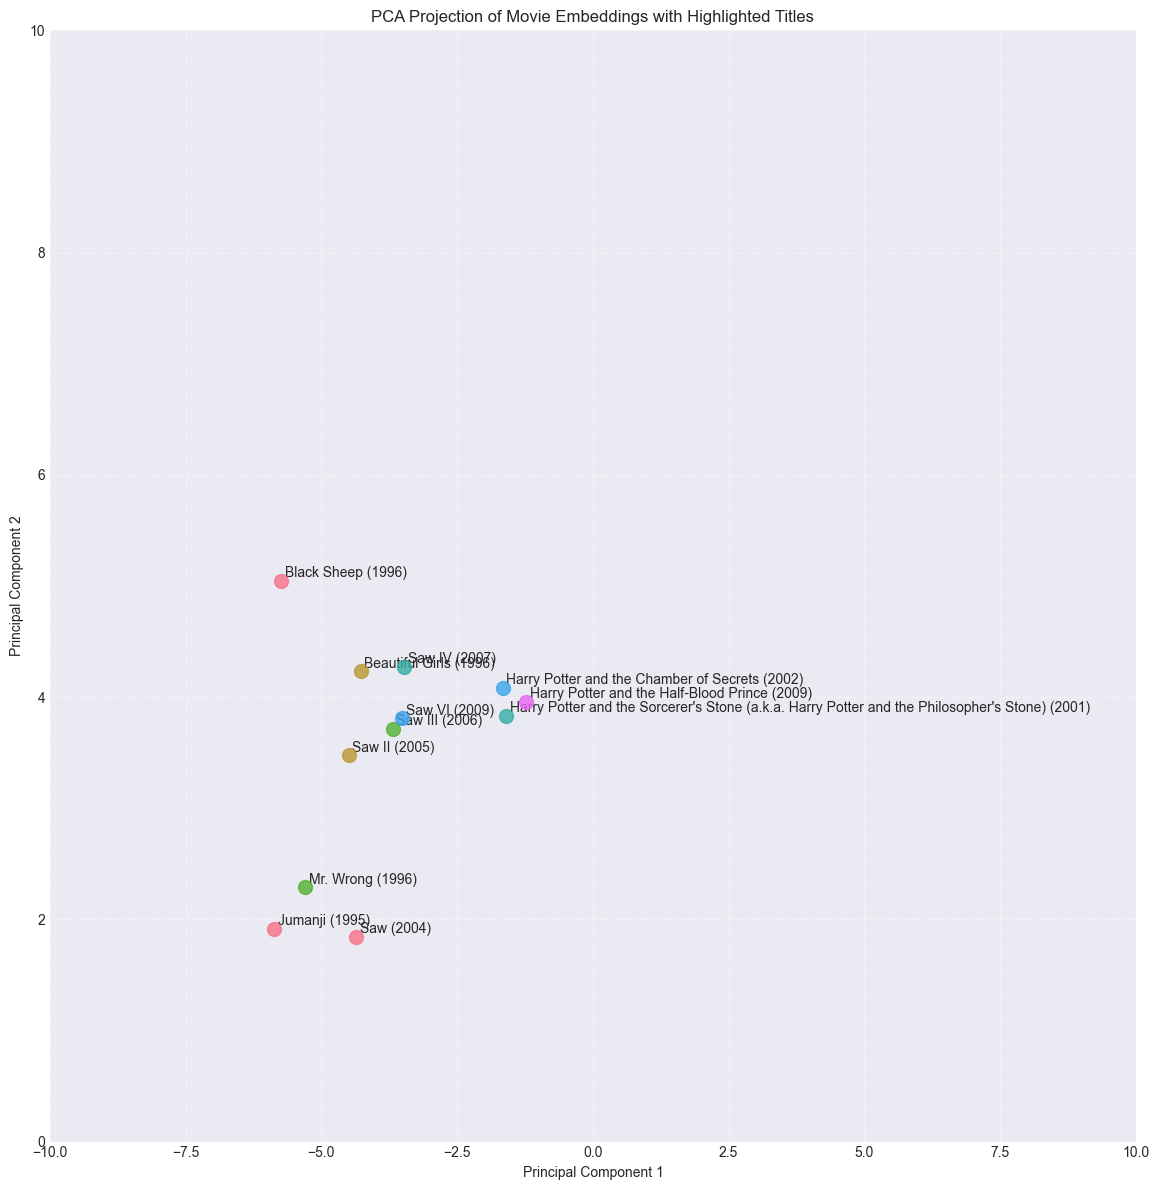

In [59]:
Standarized_movie_embeddings = StandardScaler().fit_transform(movie_embeddings.T)
movie_embeddings_2D = PCA(n_components=2).fit_transform(Standarized_movie_embeddings)


movie_ids_plot = [8957, 39446, 48877, 55577, 72129, 1, 2, 364, 6377, 4896, 5816, 69844, 88, 94, 102]

plt.figure(figsize=(12, 12)) 
plt.title("PCA Projection of Movie Embeddings with Highlighted Titles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.xlim(-10, 10)
plt.ylim(0, 10)
plt.grid(True, linestyle='--', alpha=0.5)


offset = 0.07

for movie in movie_ids_plot:
  movie_idx_plot = ratings_matrix.movieid_to_idx[movie]
  movie_x =  movie_embeddings_2D[movie_idx_plot, 0]
  movie_y =  movie_embeddings_2D[movie_idx_plot, 1]
  
  plt.scatter(movie_x, movie_y, s = 100, alpha = 0.8, zorder=5)
  
  row = df2[df2['movieId'] == movie][['title']].values[0][0]
  
  plt.annotate(
      row, 
      (movie_x, movie_y), 
      xytext=(movie_x + offset, movie_y + offset), 
      fontsize=10,
      textcoords='data',
      ha='left',
      va='center'
  )

# Ensures all elements (title, labels) fit nicely inside the figure
plt.tight_layout() 
plt.savefig('plots_pdf/movie_pca.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

1. Calculating movie popularity...
2. Collecting top 100 movies for: ['Children', 'Horror', 'Comedy', 'Documentary']...
   Found 100 movies for 'Children'
   Found 100 movies for 'Horror'
   Found 100 movies for 'Comedy'
   Found 100 movies for 'Documentary'
3. Running PCA on 400 items...
4. Generating Plot...


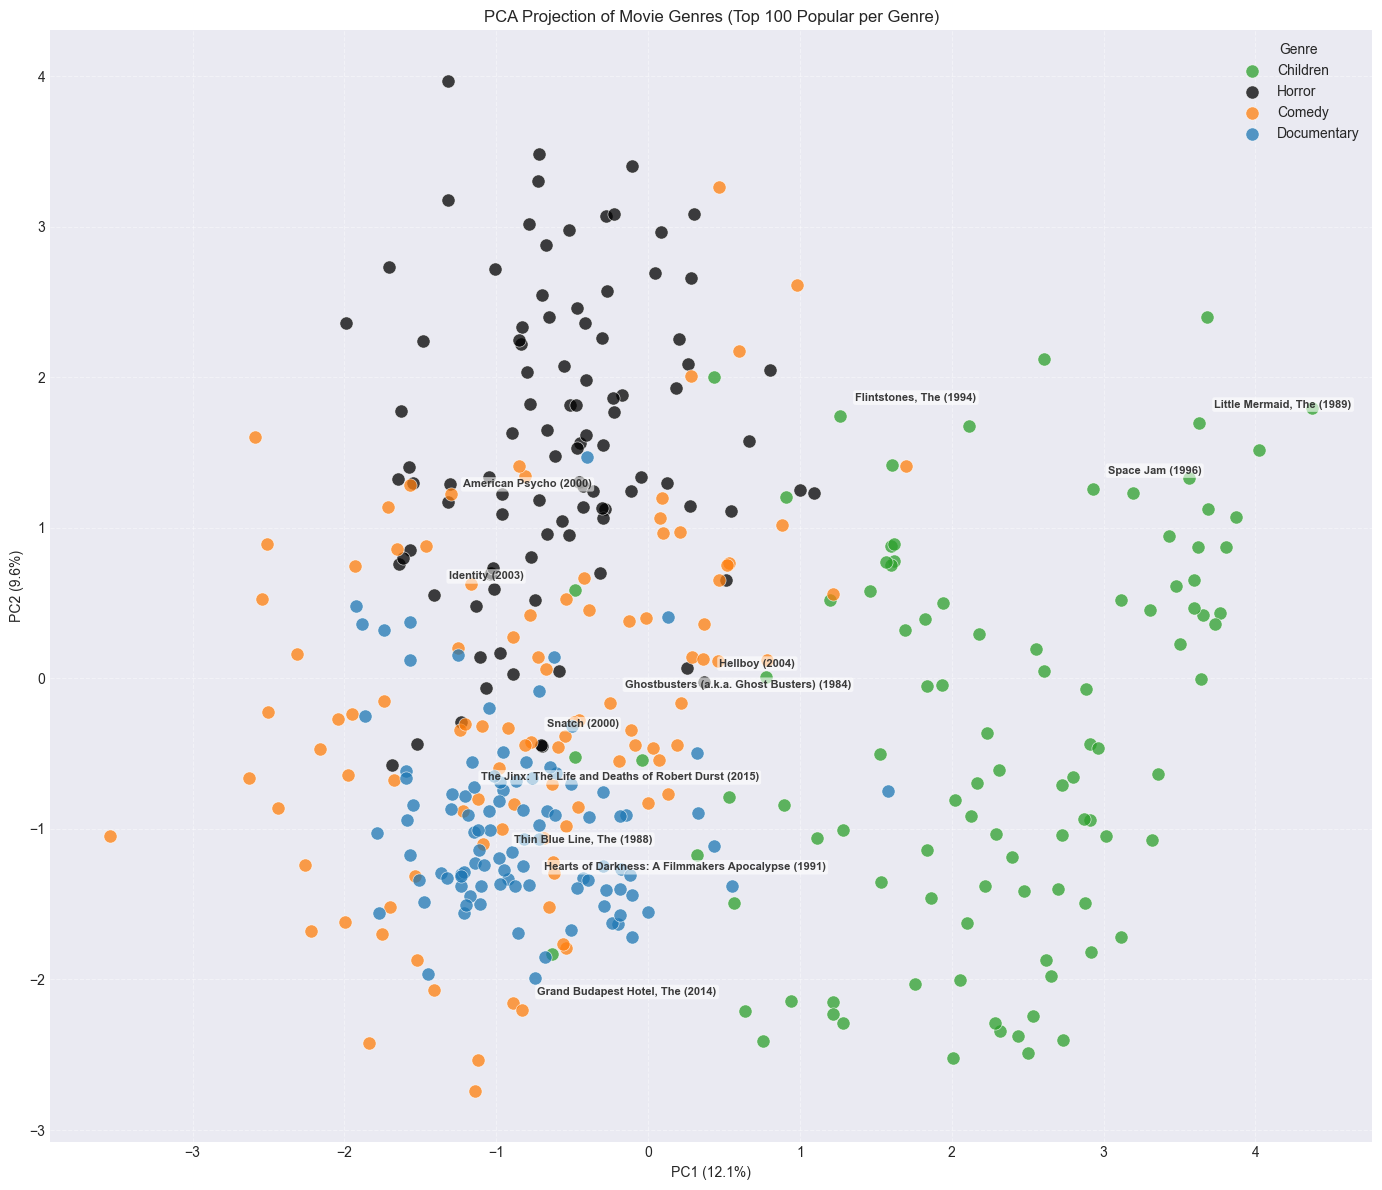

In [62]:


# ==============================================================================
# CONFIGURATION
# ==============================================================================
target_genres = ['Children', 'Horror', 'Comedy', 'Documentary']
samples_per_genre = 100

# ==============================================================================
# 1. FILTERING DATA
# ==============================================================================
print("1. Calculating movie popularity...")

# We need to find the most popular movies to ensure good quality visualization.
# Since we are using the Optimized SparseMatrix from previous steps, 
# we can get counts instantly using the CSR/CSC pointers:
if hasattr(ratings_matrix, 'movie_ptr'):
    # Optimized way (Instant)
    counts = np.diff(ratings_matrix.movie_ptr)
else:
    # Fallback if using the unoptimized class provided in prompt (Slower)
    counts = np.array([len(m) for m in ratings_matrix.data_by_movie])

# Sort indices by popularity (Descending)
sorted_indices = np.argsort(counts)[::-1]

print(f"2. Collecting top {samples_per_genre} movies for: {target_genres}...")

collected_data = {genre: [] for genre in target_genres}
seen_movies = set()

# Iterate through movies (most popular first)
for idx in sorted_indices:
    # Optimization: Stop if all buckets are full
    if all(len(collected_data[g]) >= samples_per_genre for g in target_genres):
        break
        
    # Use class mapping to get ID
    movie_id = ratings_matrix.idx_to_movieid[idx]
    
    if movie_id in seen_movies:
        continue
        
    try:
        # Look up metadata in dataframe (Assumes df2 is loaded)
        row = df2[df2['movieId'] == movie_id].values[0]
        title = row[1]
        genre_str = row[2]
        
        # Check against our targets
        for target in target_genres:
            if target in genre_str:
                # Check if we still need samples for this genre
                if len(collected_data[target]) < samples_per_genre:
                    collected_data[target].append({
                        'embedding': movie_embeddings[:, idx], # Shape (k,)
                        'title': title,
                        'genre_label': target
                    })
                    seen_movies.add(movie_id)
                    break # Assign to one genre only
    except IndexError:
        continue # Movie ID not in CSV

# Flatten data for PCA
subset_embeddings = []
subset_labels = []
subset_titles = []

for genre in target_genres:
    print(f"   Found {len(collected_data[genre])} movies for '{genre}'")
    for item in collected_data[genre]:
        subset_embeddings.append(item['embedding'])
        subset_labels.append(item['genre_label'])
        subset_titles.append(item['title'])

X = np.array(subset_embeddings)

# ==============================================================================
# 2. PCA PIPELINE
# ==============================================================================
print(f"3. Running PCA on {X.shape[0]} items...")

# Standardize first (Important for PCA)
X_std = StandardScaler().fit_transform(X)

# Compute PCA (2 Components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# ==============================================================================
# 3. VISUALIZATION
# ==============================================================================
print("4. Generating Plot...")

plt.figure(figsize=(14, 12))
plt.title("PCA Projection of Movie Genres (Top 100 Popular per Genre)")

# Define distinct colors
genre_colors = {
    'Children': 'tab:green',
    'Horror': 'black', 
    'Comedy': 'tab:orange', # Changed Sci-Fi to Comedy (Orange)
    'Documentary': 'tab:blue'
}

offset = 0.1

# Plot loop
for genre in target_genres:
    # Get indices for this specific genre
    indices = [i for i, label in enumerate(subset_labels) if label == genre]
    
    if not indices: continue
        
    # Extract points
    points_x = X_pca[indices, 0]
    points_y = X_pca[indices, 1]
    
    # Scatter
    plt.scatter(points_x, points_y, 
                c=genre_colors.get(genre, 'gray'), 
                label=genre, 
                s=90, alpha=0.75, edgecolors='white', linewidth=0.5)
    
    # Annotate a few random titles for context
    if len(indices) > 0:
        # Annotate 3 random movies per genre
        idx_to_annotate = random.sample(indices, min(3, len(indices)))
        for i in idx_to_annotate:
            plt.annotate(
                subset_titles[i], 
                (X_pca[i, 0], X_pca[i, 1]), 
                xytext=(X_pca[i, 0] + offset, X_pca[i, 1] + offset),
                fontsize=8, weight='bold', alpha=0.9,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6)
            )

# Formatting
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.legend(title="Genre", loc='best')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Save and Show
plt.savefig('plots_pdf/movie_pca_4genres.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()